In [7]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE

1. LOAD & CLEANING

In [8]:
print("--- 1. Memulai Proses Soft-Cleaning ---")
try:
    df = pd.read_csv('Dataset_Jantung_Fix.csv')
except:
    df = pd.read_csv('Dataset Penyakit Jantung.csv')

df.replace('?', np.nan, inplace=True)
cols_num = ['trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
for col in cols_num:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Hapus 0 pada kolom vital & kategori UCI
df['chol'] = df['chol'].replace(0, np.nan)
df['trestbps'] = df['trestbps'].replace(0, np.nan)
for col in ['cp', 'slope', 'thal']:
    df[col] = df[col].replace(0, np.nan)
df['thal'] = df['thal'].apply(lambda x: x if x in [3, 6, 7] else np.nan)

# Imputasi
for col in ['chol', 'oldpeak', 'ca', 'trestbps', 'thalach']: 
    df[col] = df[col].fillna(df[col].median())
for col in ['fbs', 'restecg', 'exang', 'slope', 'thal', 'cp', 'sex']: 
    df[col] = df[col].fillna(df[col].mode()[0])

--- 1. Memulai Proses Soft-Cleaning ---


2. HAPUS OUTLIER (SOFT CLEANING - IQR 2.0)

In [9]:
def hapus_outlier(data, kolom):
    Q1 = data[kolom].quantile(0.25)
    Q3 = data[kolom].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 2.0 * IQR # Batas bawah longgar
    upper = Q3 + 2.0 * IQR # Batas atas longgar
    return data[(data[kolom] >= lower) & (data[kolom] <= upper)]

df_clean = df.copy()
for col in ['trestbps', 'chol', 'thalach']:
    df_clean = hapus_outlier(df_clean, col)

print(f"Data Awal: {df.shape} -> Data Soft-Clean: {df_clean.shape}")

Data Awal: (920, 14) -> Data Soft-Clean: (886, 14)


3. TRAINING

In [10]:
df_clean['target'] = df_clean['num'].apply(lambda x: 1 if x > 0 else 0)
df_clean = df_clean.drop(columns=['num'])

X = df_clean.drop(columns=['target'])
y = df_clean['target']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocessor
cat_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
num_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('scaler', RobustScaler())]), num_features),
        ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), cat_features)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
ohe = preprocessor.named_transformers_['cat']['onehot']
feature_names = np.r_[num_features, ohe.get_feature_names_out(cat_features)]

# SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Model Training
print("Training XGBoost & DT...")
xgb_model = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss',
    n_estimators=300, 
    learning_rate=0.05, 
    max_depth=6, 
    random_state=42
)
xgb_model.fit(X_train_resampled, y_train_resampled)

dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train_resampled, y_train_resampled)

Training XGBoost & DT...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:56:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


DecisionTreeClassifier(max_depth=5, random_state=42)


--- Memulai Analisis Justifikasi Penggunaan SMOTE ---
Sedang melatih model pada data imbalance (Tanpa SMOTE)...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:56:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== TABEL JUSTIFIKASI PENGGUNAAN SMOTE ===
Perhatikan kenaikan pada kolom 'Recall (Sensitivitas)' saat menggunakan SMOTE.


,Skenario,Model,Akurasi,Recall (Sensitivitas),Precision,F1-Score
0,Tanpa SMOTE (Imbalanced),Decision Tree,0.780899,0.775510,0.817204,0.795812
2,Dengan SMOTE (Balanced),Decision Tree,0.792135,0.785714,0.827957,0.806283
1,Tanpa SMOTE (Imbalanced),XGBoost,0.797753,0.836735,0.803922,0.820000
3,Dengan SMOTE (Balanced),XGBoost,0.820225,0.857143,0.823529,0.840000


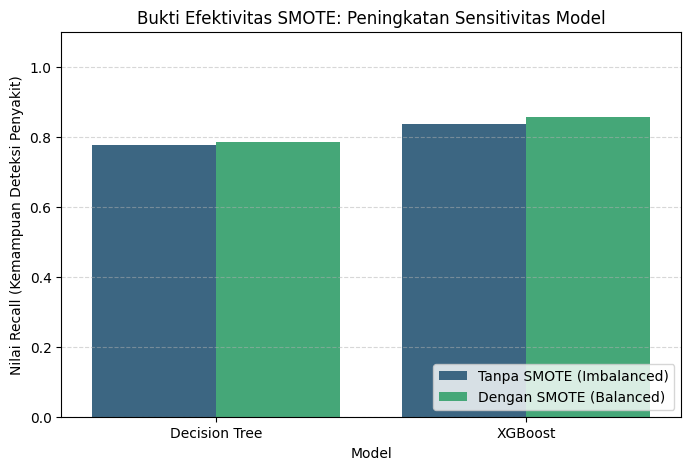

In [11]:
# ==============================================================================
# 3.2. ANALISIS JUSTIFIKASI SMOTE (STUDI KOMPARASI) - TAMBAHAN UNTUK REVISI
# ==============================================================================
print("\n--- Memulai Analisis Justifikasi Penggunaan SMOTE ---")

# 1. Training Model Tanpa SMOTE (Baseline)
# Kita gunakan X_train_processed (data asli yang hanya di-scale, BELUM di-SMOTE)
print("Sedang melatih model pada data imbalance (Tanpa SMOTE)...")

xgb_no_smote = XGBClassifier(
    use_label_encoder=False, eval_metric='logloss',
    n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42
)
xgb_no_smote.fit(X_train_processed, y_train)

dt_no_smote = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_no_smote.fit(X_train_processed, y_train)

# 2. Hitung Metrik & Bandingkan
komparasi_results = []

# A. Evaluasi Skenario Tanpa SMOTE
# Menggunakan X_test_processed dan y_test (Data Uji Asli)
for name, model_obj in {'Decision Tree': dt_no_smote, 'XGBoost': xgb_no_smote}.items():
    y_pred = model_obj.predict(X_test_processed)
    komparasi_results.append({
        'Skenario': 'Tanpa SMOTE (Imbalanced)',
        'Model': name,
        'Akurasi': accuracy_score(y_test, y_pred),
        'Recall (Sensitivitas)': recall_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    })

# B. Evaluasi Skenario Dengan SMOTE (Model Utama Anda)
# Menggunakan model 'xgb_model' dan 'dt_model' yang sudah dilatih di sel sebelumnya
for name, model_obj in {'Decision Tree': dt_model, 'XGBoost': xgb_model}.items():
    y_pred = model_obj.predict(X_test_processed)
    komparasi_results.append({
        'Skenario': 'Dengan SMOTE (Balanced)',
        'Model': name, # Nama model disamakan agar mudah dibandingkan
        'Akurasi': accuracy_score(y_test, y_pred),
        'Recall (Sensitivitas)': recall_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    })

# 3. Tampilkan Dataframe Perbandingan (Justifikasi)
df_komparasi = pd.DataFrame(komparasi_results)
# Urutkan agar mudah dibaca: Model -> Skenario
df_komparasi = df_komparasi.sort_values(by=['Model', 'Skenario'], ascending=[True, False])

print("\n=== TABEL JUSTIFIKASI PENGGUNAAN SMOTE ===")
print("Perhatikan kenaikan pada kolom 'Recall (Sensitivitas)' saat menggunakan SMOTE.")
display(df_komparasi) # Gunakan print(df_komparasi) jika tidak di Jupyter

# (Opsional) Visualisasi Perbandingan Recall
plt.figure(figsize=(8, 5))
sns.barplot(data=df_komparasi, x='Model', y='Recall (Sensitivitas)', hue='Skenario', palette='viridis')
plt.title("Bukti Efektivitas SMOTE: Peningkatan Sensitivitas Model")
plt.ylabel("Nilai Recall (Kemampuan Deteksi Penyakit)")
plt.ylim(0, 1.1)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

4. SIMPAN ARTIFACTS

In [12]:
results = []
cms = {}

for name, model in {'Decision Tree': dt_model, 'XGBoost (Tuned)': xgb_model}.items():
    y_p = model.predict(X_test_processed)
    results.append({
        'Model': name, 'Akurasi': accuracy_score(y_test, y_p),
        'Recall': recall_score(y_test, y_p), 'Precision': precision_score(y_test, y_p),
        'F1-Score': f1_score(y_test, y_p)
    })
    cms[name] = confusion_matrix(y_test, y_p)

artifacts = {
    'model_xgb': xgb_model,          # Kunci sesuai app Anda
    'preprocessor': preprocessor,
    'feature_names': feature_names,
    'X_train_sample': X_train_resampled[:100], # Kunci sesuai app Anda
    'comparison_metrics': pd.DataFrame(results), # Kunci sesuai app Anda
    'confusion_matrices': cms        # Kunci sesuai app Anda
}

joblib.dump(artifacts, 'model_jantung.pkl')
print("\n✅ FILE 'model_jantung.pkl' SIAP. Kunci dictionary sudah disamakan dengan App.")


✅ FILE 'model_jantung.pkl' SIAP. Kunci dictionary sudah disamakan dengan App.
